# understanding CC pair reactivity trends

# Summary

[only noncanonical pair that has less under -5.45 for 1x1](#percent-under--5.45)<br>
[Has strong dependence of 5' and 3' residues on reactivity](#stacking-trends)<br>
[Reactivity between the two Cs is asymmetrical](#ratio-in-reactivity)

# Setup

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress, ttest_ind
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tabulate import tabulate
import py3Dmol

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    plot_motif_boxplot_stripplot,
    plot_violins_w_percent,
    plot_violins_w_percent_groups,
    format_small_plot,
)
from dms_3d_features.format_tables import (
    dataframe_column_table,
    generate_threshold_summary,
    heatmap_table,
)
from dms_3d_features.stats import r2, check_pairwise_statistical_significance

## extra functions

In [122]:
def visualize_molecule(row, width=400, height=300):
    viewer = py3Dmol.view(width=width, height=height)
    viewer.addModel(open("../" + row["pdb_path"], "r").read(), "pdb")

    # Set color scheme for nucleotides
    nucleotide_colors = {"A": "red", "U": "green", "C": "blue", "G": "orange"}
    for nuc, color in nucleotide_colors.items():
        viewer.setStyle({"resn": nuc}, {"stick": {"color": color}})

    viewer.zoomTo()

    residue_number = row["pdb_r_pos"]
    viewer.addStyle({"resi": str(residue_number)}, {"stick": {"color": "magenta"}})

    # Highlight N1 for A or N3 for C
    if row["r_nuc"] == "A":
        viewer.addStyle(
            {"resi": str(residue_number), "atom": "N1"},
            {"sphere": {"radius": 1.0, "color": "magenta"}},
        )
    elif row["r_nuc"] == "C":
        viewer.addStyle(
            {"resi": str(residue_number), "atom": "N3"},
            {"sphere": {"radius": 1.0, "color": "magenta"}},
        )

    return viewer

### plotting

In [123]:
def plot_residue_trends(df, color="tab:gray", col="ln_r_data"):
    fig = plt.figure(figsize=(3.0, 3.0), dpi=200)
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[:, 1])

    # 5' Residue
    data_range = df[col].max() - df[col].min()
    extra_space = 0.4 * data_range
    xlim_min = df[col].min() - extra_space
    xlim_max = df[col].max()

    plot_violins_w_percent(
        df,
        col,
        "p5_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax1,
    )
    ax1.set_ylabel("5' Residue", labelpad=2)
    ax1.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax1)

    # 3' Residue
    plot_violins_w_percent(
        df,
        col,
        "p3_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax2,
    )
    ax2.set_ylabel("3' Residue", labelpad=2)
    ax2.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax2)

    # Residue Stack
    plot_violins_w_percent(
        df,
        col,
        "r_stack",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax3,
    )
    ax3.set_ylabel("Residue Stack", labelpad=2)
    ax3.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax3)
    plt.tight_layout()

In [124]:
def plot_flanking_pairs_distribution(df):
    # Combine the flanking pairs into a single column
    df["flanking_pairs"] = df["m_second_flank_bp_5p"] + "-" + df["m_second_flank_bp_3p"]
    # Calculate mean r_data_ratio for each flanking pair
    mean_r_data_ratio = (
        df.groupby("flanking_pairs")["r_data_ratio"].mean().sort_values(ascending=False)
    )
    # Create the rotated violin plot
    plt.figure(figsize=(5, 4))
    sns.violinplot(
        x="r_data_ratio",
        y="flanking_pairs",
        data=df,
        order=mean_r_data_ratio.index[::-1],
        cut=0,
        orient="h",
        density_norm="width",
    )
    # Customize the plot
    plt.title("Distribution of r_data_ratio for Different Flanking Pairs")
    plt.xlabel("r_data_ratio")
    plt.ylabel("Flanking Pairs (5' - 3')")
    # Add count labels
    counts = df["flanking_pairs"].value_counts()
    for i, flanking_pair in enumerate(mean_r_data_ratio.index[::-1]):
        count = counts[flanking_pair]
        plt.text(plt.xlim()[1] + 0.5, i, f"n={count}", ha="left", va="center")

### summary tables

In [125]:
def create_summary_table(df, y_column):
    # Calculate percentages and counts
    summary = []
    for y_value in df[y_column].unique():
        group = df[df[y_column] == y_value]
        percent_over = (group["ln_r_data"] < -5.45).mean() * 100
        count = len(group)
        summary.append([y_value, f"{percent_over:.2f}%", count])

    # Sort by percentage descending
    summary.sort(key=lambda x: float(x[1][:-1]), reverse=True)

    # Create table
    headers = [y_column, "% Under -5.45", "Count"]
    table = tabulate(summary, headers=headers, tablefmt="pipe", floatfmt=".2f")

    print(f"Summary table for {y_column}:")
    print(table)

In [126]:
def analyze_flanking_pairs(df):
    # Calculate the mean of r_data_ratio for each combination of m_second_flank_bp_5p and m_second_flank_bp_3p
    mean_r_data_ratio = (
        df.groupby(["m_second_flank_bp_5p", "m_second_flank_bp_3p"])["r_data_ratio"]
        .mean()
        .reset_index()
    )
    # Pivot the table to create a matrix-like structure
    pivot_table = mean_r_data_ratio.pivot(
        index="m_second_flank_bp_5p",
        columns="m_second_flank_bp_3p",
        values="r_data_ratio",
    )
    # Sort the index and columns alphabetically
    pivot_table = pivot_table.sort_index().sort_index(axis=1)
    # Display the results as a styled table
    display(pivot_table.style.format("{:.1f}").background_gradient(cmap="YlOrRd"))
    # Calculate the count of occurrences for each combination
    count_table = (
        df.groupby(["m_second_flank_bp_5p", "m_second_flank_bp_3p"])
        .size()
        .reset_index(name="count")
    )
    pivot_count = count_table.pivot(
        index="m_second_flank_bp_5p", columns="m_second_flank_bp_3p", values="count"
    )
    pivot_count = pivot_count.sort_index().sort_index(axis=1)
    # Display the count table
    display(pivot_count.style.format("{:.1f}").background_gradient(cmap="Blues"))

### misc

In [127]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "both_pyrimidine"
    elif row["both_purine"]:
        return "both_purine"
    else:
        return "mixed"

In [128]:
def add_side_diff_column(df):
    df["side_diff"] = [
        abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df["m_token"]
    ]
    df["side_diff"] = df["side_diff"].astype(str)
    return df

## load data

In [129]:
DATA_PATH = "../data"

In [130]:
df_constructs = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df = df.query('m_token != "4x4"').copy()
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
# pdb dataframe
df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
df_pdb_cc = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-C' and no_of_interactions == 1"
).copy()

In [132]:
dataframe_column_table(df_pdb)

                         0                    1                   2                  3
                m_sequence                r_nuc           pdb_r_pos             r_type
             pdb_r_bp_type           pdb_r_pair no_of_conformations no_of_interactions
no_of_partner_interactions             pdb_name            pdb_path            pdb_res
               both_purine      both_pyrimidine          constructs        likely_pair
             m_flank_bp_5p        m_flank_bp_3p       m_orientation              m_pos
      m_second_flank_bp_5p m_second_flank_bp_3p         m_structure            m_token
                    n_pdbs            pair_type              p5_res            p5_type
                    p3_res              p3_type              r_data          r_loc_pos
                     r_pos              r_stack           ln_r_data            z_score
            r_data_outlier       pair_pdb_r_pos                 NaN                NaN


# All residues

## percent under -5.45

In [133]:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
print(len(df_cc["m_sequence"].unique()))

83


In [134]:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
generate_threshold_summary(df_cc, "r_nuc", greater_than=False)

Summary table for r_nuc:
| r_nuc   | % < -5.45   |   Count |
|:--------|:------------|--------:|
| C       | 5.52%       |   14150 |


In [135]:
df_cc = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC' and m_token == '1x1'"
).copy()
generate_threshold_summary(df_cc, "r_nuc", greater_than=False)

Summary table for r_nuc:
| r_nuc   | % < -5.45   |   Count |
|:--------|:------------|--------:|
| C       | 0.89%       |     672 |


## Stacking trends

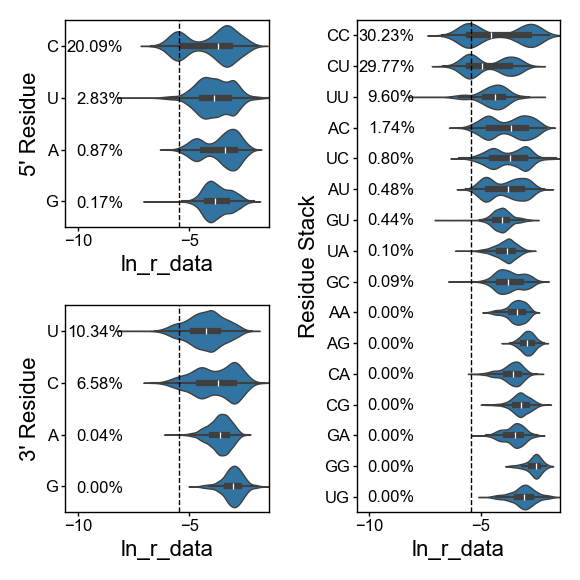

In [136]:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
plot_residue_trends(df_cc, color="tab:blue")

In [137]:
# Example usage:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
p_values_df = check_pairwise_statistical_significance(df_cc, "r_stack", "ln_r_data")
p_values_df.sort_values(by="p-value", ascending=True)

,Group 1,Group 2,p-value
119,UG,UU,0.000000e+00
38,AG,UA,0.000000e+00
41,AG,UU,0.000000e+00
14,AA,UU,4.714562e-307
33,AG,CU,7.402265e-256
...,...,...,...
22,AC,GC,7.418314e-03
58,CA,GC,1.201028e-02
102,GC,UC,2.206930e-02
26,AC,UC,5.674827e-01


In [138]:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
p_values_df = check_pairwise_statistical_significance(df_cc, "p5_res", "ln_r_data")
p_values_df.sort_values(by="p-value", ascending=True)

,Group 1,Group 2,p-value
0,A,C,4.231715e-73
2,A,U,5.016418e-45
3,C,G,6.863201e-39
4,C,U,1.495123e-18
5,G,U,1.746009e-11
1,A,G,1.303618e-10


In [139]:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
p_values_df = check_pairwise_statistical_significance(df_cc, "p3_res", "ln_r_data")
p_values_df.sort_values(by="p-value", ascending=True)

,Group 1,Group 2,p-value
3,C,G,0.000000e+00
5,G,U,0.000000e+00
1,A,G,2.837356e-291
2,A,U,3.639667e-281
4,C,U,6.679715e-122
0,A,C,2.146641e-33


/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


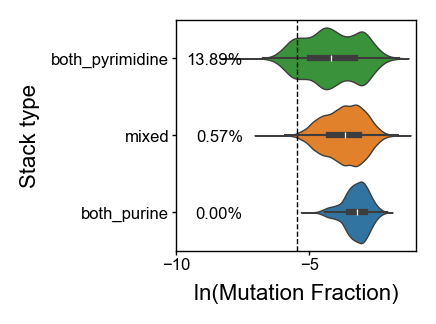

In [140]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
df_cc["stack_type"] = df_cc.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_cc,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
format_small_plot(ax)

In [141]:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
create_summary_table(df_cc, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CC        | 30.23%          |    1171 |
| CU        | 29.77%          |     813 |
| UU        | 9.60%           |    1334 |
| AC        | 1.74%           |    1835 |
| UC        | 0.80%           |    2011 |
| AU        | 0.48%           |    1047 |
| GU        | 0.44%           |     451 |
| UA        | 0.10%           |    1035 |
| GC        | 0.09%           |    1105 |
| AA        | 0.00%           |     839 |
| GA        | 0.00%           |     232 |
| AG        | 0.00%           |     522 |
| CA        | 0.00%           |     623 |
| CG        | 0.00%           |     360 |
| UG        | 0.00%           |     744 |
| GG        | 0.00%           |      28 |


## Ratio in reactivity

In [142]:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
new_rows = []
count = 0
for i, group in df_cc.groupby(["m_sequence", "constructs", "m_pos"]):
    if len(group) == 2:
        sorted_group = group.sort_values(by="r_data", ascending=True)
        new_row = sorted_group.iloc[0].copy()
        new_row["r_data_ratio"] = (
            sorted_group.iloc[1]["r_data"] / sorted_group.iloc[0]["r_data"]
        )
        new_row["r_data_other"] = sorted_group.iloc[1]["r_data"]
        new_row["r_stack_other"] = sorted_group.iloc[1]["r_stack"]
        new_row["p5_res_other"] = sorted_group.iloc[1]["p5_res"]
        new_row["p3_res_other"] = sorted_group.iloc[1]["p3_res"]
        new_rows.append(new_row)
    else:
        count += 1
df_cc_combined = pd.DataFrame(new_rows)
print(count, len(df_cc_combined))

672 5731


In [143]:
df_cc_combined = df_cc_combined.sort_values(by="r_data_ratio", ascending=False)

In [144]:
dataframe_column_table(df_cc_combined)

           0                    1                    2             3
 both_purine      both_pyrimidine           constructs      has_pdbs
 likely_pair        m_flank_bp_5p        m_flank_bp_3p m_orientation
       m_pos m_second_flank_bp_5p m_second_flank_bp_3p    m_sequence
 m_structure              m_token               n_pdbs     pair_type
      p5_res              p5_type               p3_res       p3_type
      r_data                r_nuc            r_loc_pos         r_pos
      r_type              r_stack             pdb_path     pdb_r_pos
   ln_r_data              z_score       r_data_outlier  r_data_ratio
r_data_other        r_stack_other         p5_res_other  p3_res_other


### what is related to large ratios in reactivity

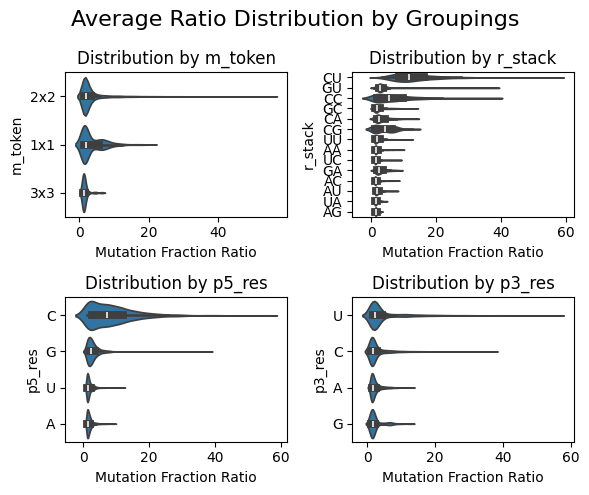

In [145]:
# Calculate average ratio for different groupings
groupings = ["m_token", "r_stack", "p5_res", "p3_res"]

fig, axes = plt.subplots(2, 2, figsize=(6, 5))
fig.suptitle("Average Ratio Distribution by Groupings", fontsize=16)

for idx, group in enumerate(groupings):
    row = idx // 2
    col = idx % 2

    # Create violin plot
    sns.violinplot(
        x="r_data_ratio",
        y=group,
        data=df_cc_combined,
        ax=axes[row, col],
        orient="h",
        density_norm="width",
    )

    axes[row, col].set_title(f"Distribution by {group}")
    axes[row, col].set_xlabel("Mutation Fraction Ratio")
    axes[row, col].set_ylabel(group)

plt.tight_layout()
plt.show()

In [146]:
df_cc_combined.groupby(["r_stack", "r_stack_other"]).agg(
    mean_r_data_ratio=("r_data_ratio", "mean"),
    std_r_data_ratio=("r_data_ratio", "std"),
    count=("r_data_ratio", "count"),
).reset_index().sort_values(by="mean_r_data_ratio", ascending=False)
### what motifs have the highest ratios

,r_stack,r_stack_other,mean_r_data_ratio,std_r_data_ratio,count
21,CU,UG,13.679566,6.561883,394
17,CC,UG,10.141688,6.264962,289
20,CU,AG,7.997563,4.722059,30
16,CC,GG,7.866761,2.288855,28
14,CA,UG,7.638615,2.167892,30
19,CG,UG,6.372812,1.952836,31
28,GU,UC,3.217675,2.130078,401
26,GC,UC,3.126526,2.419252,305
22,GA,AC,3.072963,1.658470,202
13,CA,AG,2.780262,1.518267,198


In [147]:
df_cc_combined.query('m_token == "2x2"').groupby(["r_stack", "r_stack_other"]).agg(
    mean_r_data_ratio=("r_data_ratio", "mean"),
    std_r_data_ratio=("r_data_ratio", "std"),
    count=("r_data_ratio", "count"),
).reset_index().sort_values(by="mean_r_data_ratio", ascending=False)

,r_stack,r_stack_other,mean_r_data_ratio,std_r_data_ratio,count
13,CU,UG,13.679566,6.561883,394
12,CC,UG,10.141688,6.264962,289
17,GU,UC,3.217675,2.130078,401
16,GC,UC,3.126526,2.419252,305
14,GA,AC,3.072963,1.658470,202
10,CA,AG,2.780262,1.518267,198
0,AA,AU,2.702813,1.625757,193
26,UU,UA,2.498531,1.258847,370
9,AU,UU,2.351907,0.953729,372
5,AC,UU,2.281524,1.482911,273


### what motifs have the highest ratios

In [148]:
df_cc_combined = df_cc_combined.sort_values(by="r_data_ratio", ascending=False)

In [149]:
from tabulate import tabulate

# Calculate the average r_data_ratio for each unique m_sequence and r_stack combination
average_ratios = (
    df_cc_combined.groupby(["m_sequence", "r_stack"])["r_data_ratio"]
    .mean()
    .sort_values(ascending=False)
)

# Get the top 10 and bottom 10 unique m_sequences and r_stack combinations
top_10_sequences = average_ratios.head(10).reset_index()
bottom_10_sequences = average_ratios.tail(10).reset_index()

# Create table for top 10
print("Top 10 Unique m_sequences and r_stack combinations with Highest Average Ratio:")
print(
    tabulate(
        top_10_sequences,
        headers=["m_sequence", "r_stack", "Average r_data_ratio"],
        tablefmt="pipe",
        floatfmt=".2f",
    )
)

print("\n")  # Add a blank line for separation

# Create table for bottom 10
print(
    "Bottom 10 Unique m_sequences and r_stack combinations with Lowest Average Ratio:"
)
print(
    tabulate(
        bottom_10_sequences,
        headers=["m_sequence", "r_stack", "Average r_data_ratio"],
        tablefmt="pipe",
        floatfmt=".2f",
    )
)

Top 10 Unique m_sequences and r_stack combinations with Highest Average Ratio:
|    | m_sequence   | r_stack   |   Average r_data_ratio |
|---:|:-------------|:----------|-----------------------:|
|  0 | CCUC&GUCG    | CU        |                  16.56 |
|  1 | CCCG&CUCG    | CC        |                  16.19 |
|  2 | CCUA&UUCG    | CU        |                  12.76 |
|  3 | CCUG&CUCG    | CU        |                  12.75 |
|  4 | AUCG&CCUU    | CU        |                  12.60 |
|  5 | ACG&CCU      | CU        |                   8.00 |
|  6 | CCC&GCG      | CC        |                   7.87 |
|  7 | CCA&UCG      | CA        |                   7.64 |
|  8 | AUCG&CCCU    | CC        |                   7.60 |
|  9 | CCCA&UUCG    | CC        |                   6.64 |


Bottom 10 Unique m_sequences and r_stack combinations with Lowest Average Ratio:
|    | m_sequence   | r_stack   |   Average r_data_ratio |
|---:|:-------------|:----------|-----------------------:|
|  0 | AUCA&

<Axes: xlabel='Nucleotide', ylabel='Mutation Fraction'>

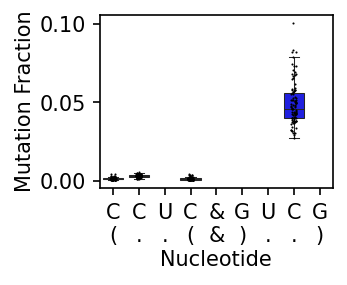

In [150]:
df_sub = df.query('m_sequence == "CCUC&GUCG"')
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=150)
plot_motif_boxplot_stripplot(df_sub, show_structure=True, ax=ax)

IndexError: single positional indexer is out-of-bounds

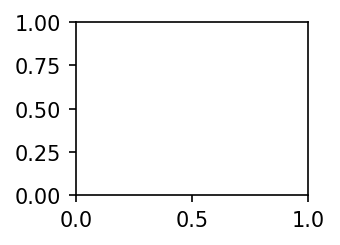

In [151]:
df_sub = df.query('m_sequence == "CGACCA&UCUUAG"')
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=150)
plot_motif_boxplot_stripplot(df_sub, show_structure=True, ax=ax)

### which pdbs have the highest ratios

In [ ]:
# Find the row with the highest ratio that has a PDB
highest_ratio_with_pdb = (
    df_cc_combined[df_cc_combined["has_pdbs"] == True]
    .sort_values(by="r_data_ratio", ascending=False)
    .iloc[1]
)

print(f"Highest ratio with PDB: {highest_ratio_with_pdb['r_data_ratio']:.2f}")
print(f"PDB path: {highest_ratio_with_pdb['pdb_path']}")
print(f"m_token: {highest_ratio_with_pdb['m_token']}")

Highest ratio with PDB: 17.86
PDB path: ['data/pdbs_w_2bp/ACG_CCU/TWOWAY.7JQC.1-1.CCU-ACG.0.pdb', 'data/pdbs_w_2bp/ACG_CCU/TWOWAY.4YHW.1-1.ACG-CCU.0.pdb']
m_token: 1x1


In [ ]:
# Example usage:
highest_ratio_with_pdb["pdb_path"] = highest_ratio_with_pdb["pdb_path"][0]
viewer = visualize_molecule(highest_ratio_with_pdb)
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### why is there a large spread

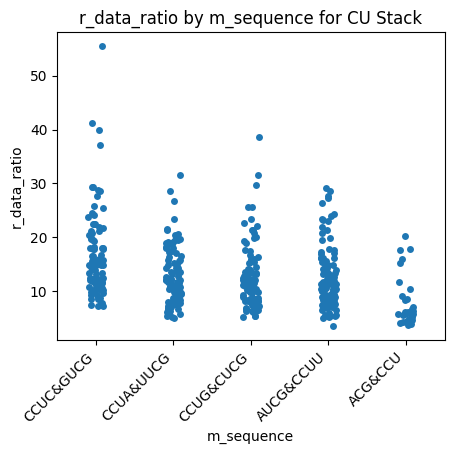

In [ ]:
# Filter and sort data for CU stack
df_cu_stack = df_cc_combined.query("r_stack == 'CU'").sort_values(
    by="r_data_ratio", ascending=False
)

# Calculate average r_data_ratio for each unique m_sequence
avg_ratios = (
    df_cu_stack.groupby("m_sequence")["r_data_ratio"]
    .mean()
    .sort_values(ascending=False)
)

# Create stripplot
plt.figure(figsize=(5, 4))
sns.stripplot(
    x="m_sequence", y="r_data_ratio", data=df_cu_stack, order=avg_ratios.index
)

# Set plot labels and title
plt.xlabel("m_sequence")
plt.ylabel("r_data_ratio")
plt.xticks(rotation=45, ha="right")

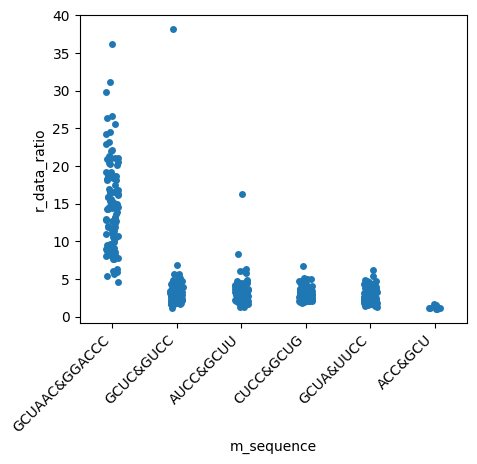

In [ ]:
# Filter and sort data for CU stack
df_cu_stack = df_cc_combined.query("r_stack == 'GU'").sort_values(
    by="r_data_ratio", ascending=False
)

# Calculate average r_data_ratio for each unique m_sequence
avg_ratios = (
    df_cu_stack.groupby("m_sequence")["r_data_ratio"]
    .mean()
    .sort_values(ascending=False)
)

# Create stripplot
plt.figure(figsize=(5, 4))
sns.stripplot(
    x="m_sequence", y="r_data_ratio", data=df_cu_stack, order=avg_ratios.index
)

# Set plot labels and title
plt.xlabel("m_sequence")
plt.ylabel("r_data_ratio")
plt.xticks(rotation=45, ha="right")

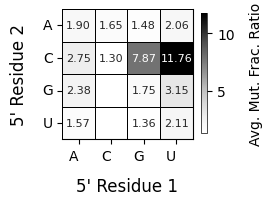

In [ ]:
def create_heatmap(df, value_col, index_col, column_col, figsize=(2, 2)):
    # Create a pivot table for the heatmap
    pivot_table = df.pivot_table(
        values=value_col, index=index_col, columns=column_col, aggfunc="mean"
    )
    # Create the heatmap with improved aesthetics
    fig, ax = plt.subplots(figsize=figsize)
    heatmap = sns.heatmap(
        pivot_table,
        annot=True,
        cmap="Greys",
        fmt=".2f",
        cbar_kws={
            "label": f"Avg. {value_col}",
            "orientation": "vertical",
            "use_gridspec": False,  # This allows us to position the colorbar
            "location": "right",
            "pad": 0.01,  # Reduce space between heatmap and colorbar
        },
        ax=ax,
        annot_kws={"size": 8},  # Reduce the font size of the text in cells
        linewidths=0.5,  # Add lines between each cell
        linecolor="black",  # Set the color of the lines to black
        square=True,  # Ensure cells are square
    )
    # Remove the lines on the left and top
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # Keep the lines on the right and bottom
    ax.spines["right"].set_visible(True)
    ax.spines["bottom"].set_visible(True)

    # Adjust colorbar to match plot height
    cbar = heatmap.collections[0].colorbar
    cbar.ax.set_position([0.82, 0.15, 0.03, 0.7])  # Reduced width from 0.05 to 0.03
    cbar.outline.set_linewidth(0.5)
    cbar.outline.set_edgecolor("black")

    return fig, ax


fig, ax = create_heatmap(df_cc_combined, "r_data_ratio", "p5_res", "p5_res_other")
ax.set_xlabel(f"5' Residue 1", fontsize=12, labelpad=10)
ax.set_ylabel(f"5' Residue 2", fontsize=12, labelpad=10)

# Adjust tick labels and rotate y-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Set color bar label
cbar = ax.collections[0].colorbar
cbar.set_label("Avg. Mut. Frac. Ratio", fontsize=10, labelpad=10)

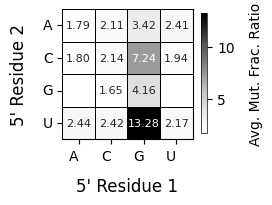

In [ ]:
fig, ax = create_heatmap(df_cc_combined, "r_data_ratio", "p3_res", "p3_res_other")
ax.set_xlabel(f"5' Residue 1", fontsize=12, labelpad=10)
ax.set_ylabel(f"5' Residue 2", fontsize=12, labelpad=10)

# Adjust tick labels and rotate y-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Set color bar label
cbar = ax.collections[0].colorbar
cbar.set_label("Avg. Mut. Frac. Ratio", fontsize=10, labelpad=10)

In [ ]:
heatmap_table(df_cc_combined, "p5_res", "p5_res_other", "r_data_ratio")

p5_res_other,A,C,G,U
p5_res,,,,
A,1.9,1.7,1.5,2.1
C,2.7,1.3,7.9,11.8
G,2.4,nan,1.7,3.2
U,1.6,nan,1.4,2.1
p5_res_other,A,C,G,U
p5_res,,,,
A,1.12,0.45,0.47,1.09
C,2.39,0.31,2.29,6.57
G,1.46,nan,0.58,2.25


In [ ]:
heatmap_table(df_cc_combined, "p3_res", "p3_res_other", "r_data_ratio")

p3_res_other,A,C,G,U
p3_res,,,,
A,1.8,2.1,3.4,2.4
C,1.8,2.1,7.2,1.9
G,nan,1.7,4.2,nan
U,2.4,2.4,13.3,2.2
p3_res_other,A,C,G,U
p3_res,,,,
A,0.77,1.36,2.30,1.53
C,0.88,1.74,6.31,1.25
G,nan,0.45,2.93,nan


#### Is there a relationship between the number of aligned residues and the reactivity ratio?
Doesnt appear to be

Text(0.5, 1.0, 'Scatter plot of r_data_ratio vs num_aligned')

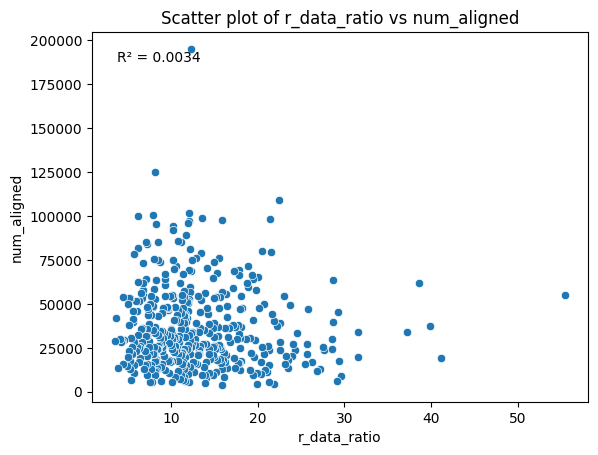

In [ ]:
# Function to get num_aligned and sn for a given construct
def get_construct_info(construct_name):
    construct_row = df_constructs[df_constructs["name"] == construct_name].iloc[0]
    return construct_row["num_aligned"], construct_row["sn"]


# Apply the function to each row in df_cc_1x1
df_cu_stack["num_aligned"], df_cu_stack["sn"] = zip(
    *df_cu_stack["constructs"].apply(get_construct_info)
)

# Create the scatter plot
sns.scatterplot(x="r_data_ratio", y="num_aligned", data=df_cu_stack)

# Calculate r2
slope, intercept, r_value, p_value, std_err = linregress(
    df_cu_stack["r_data_ratio"], df_cu_stack["num_aligned"]
)
r2 = r_value**2

# Add r2 value to the plot
plt.text(
    0.05,
    0.95,
    f"R² = {r2:.4f}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    horizontalalignment="left",
)

plt.xlabel("r_data_ratio")
plt.ylabel("num_aligned")
plt.title("Scatter plot of r_data_ratio vs num_aligned")

#### is there anything intersting in the worst ratio

In [ ]:
# Create a DataFrame with the last row of df_cu_stack
last_row_df = pd.DataFrame(df_cu_stack.iloc[-1]).T
# Reset the index to make the row index a column
last_row_df = last_row_df.reset_index()
# Melt the DataFrame to create a table with multiple columns
melted_df = pd.melt(
    last_row_df, id_vars=["index"], var_name="row_index", value_name="value"
)
melted_df["row"] = melted_df["row_index"] + " = " + melted_df["value"].astype(str)

num_columns = 4
melted_df["display_column"] = melted_df.index % num_columns
melted_df["display_row"] = melted_df.index // num_columns
melted_df.drop(columns=["index"], inplace=True)

pivot_data = melted_df.pivot(
    index="display_row", columns="display_column", values="row"
)
pivot_data.columns.name = None
pivot_data.index.name = None
pivot_data

,0,1,2,3
0,both_purine = False,both_pyrimidine = True,constructs = construct4787,has_pdbs = False
1,likely_pair = CC,m_flank_bp_5p = AU,m_flank_bp_3p = GC,m_orientation = non-flipped
2,m_pos = 2,m_second_flank_bp_5p = CG,m_second_flank_bp_3p = GC,m_sequence = AUCG&CCUU
3,m_structure = (..(&)..),m_token = 2x2,n_pdbs = 0,pair_type = nan
4,p5_res = C,p5_type = PYRIMIDINE,p3_res = U,p3_type = PYRIMIDINE
5,r_data = 0.007980000000000001,r_nuc = C,r_loc_pos = 6,r_pos = 93
6,r_type = NON-WC,r_stack = CU,pdb_path = [],pdb_r_pos = 12
7,ln_r_data = -4.8308168675,z_score = 3.2111344482,r_data_outlier = True,r_data_ratio = 3.5275689223057642
8,r_data_other = 0.02815,r_stack_other = UG,num_aligned = 28959,sn = 7.88


<Axes: >

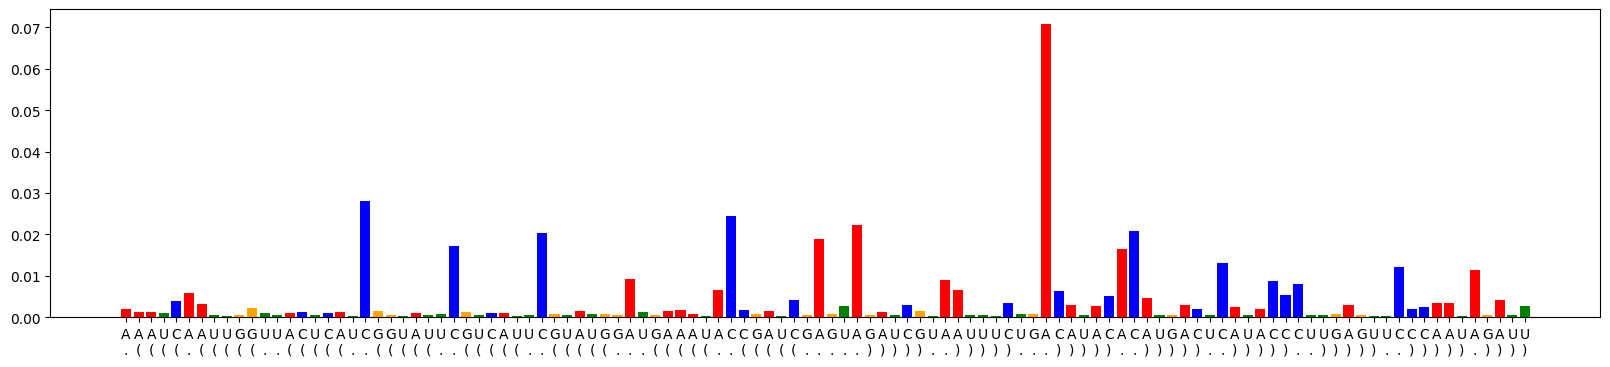

In [ ]:
# lowest ratio G
plot_pop_avg_from_row(df_constructs.query("name == 'construct4787'").iloc[0])

### is the large spread in ratio related to second flanking base pairs

In [ ]:
# Calculate the mean of r_data_ratio for each m_orientation
mean_r_data_ratio = (
    df_cu_stack.groupby("m_orientation")["r_data_ratio"].mean().reset_index()
)
# Display the results as a table
display(mean_r_data_ratio.style.format({"r_data_ratio": "{:.2f}"}))

,m_orientation,r_data_ratio
0,flipped,12.83
1,non-flipped,13.73


In [ ]:
heatmap_table(
    df_cu_stack, "m_second_flank_bp_5p", "m_second_flank_bp_3p", "r_data_ratio"
)

m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,10.5,12.0,9.9,9.2
CG,13.1,18.2,16.5,14.5
GC,16.8,22.0,17.3,12.9
UA,14.1,16.4,12.3,12.0
m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,3.29,4.56,3.26,4.12
CG,8.13,7.00,6.70,7.01
GC,5.53,11.42,6.18,7.92


In [ ]:
heatmap_table(
    df_cc_combined, "m_second_flank_bp_5p", "m_second_flank_bp_3p", "r_data_ratio"
)

m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,3.6,3.7,3.5,3.5
CG,3.5,4.2,3.8,3.4
GC,4.7,5.5,4.3,4.0
UA,4.0,3.7,3.8,3.6
m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,3.79,4.38,3.74,3.88
CG,4.04,5.52,5.11,4.68
GC,6.09,7.97,5.38,4.92


In [ ]:
df_cu_stack.groupby("m_second_flank_bp_5p").agg(
    mean_r_data_ratio=("r_data_ratio", "mean"),
    count=("r_data_ratio", "count"),
).reset_index()

,m_second_flank_bp_5p,mean_r_data_ratio,count
0,AU,10.168284,137
1,CG,15.291897,62
2,GC,16.508345,90
3,UA,13.353869,135


In [ ]:
df_cu_stack.groupby("m_second_flank_bp_3p").agg(
    mean_r_data_ratio=("r_data_ratio", "mean"),
    count=("r_data_ratio", "count"),
).reset_index()

,m_second_flank_bp_3p,mean_r_data_ratio,count
0,AU,13.418829,129
1,CG,16.668118,69
2,GC,13.096200,86
3,UA,11.587669,140


In [ ]:
df_cu_stack.groupby("r_stack_other").agg(
    mean_r_data_ratio=("r_data_ratio", "mean"),
    count=("r_data_ratio", "count"),
).reset_index()

,r_stack_other,mean_r_data_ratio,count
0,AG,7.997563,30
1,UG,13.679566,394


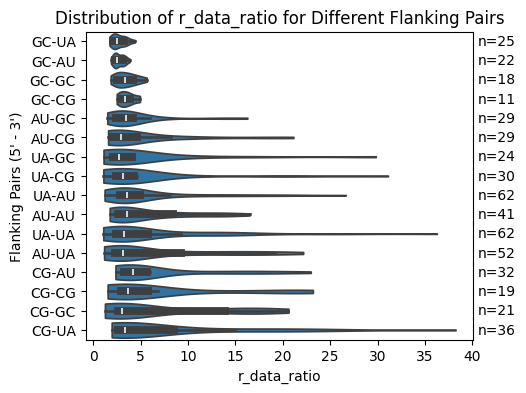

In [ ]:
plot_flanking_pairs_distribution(df_cu_stack)

# single mismatches

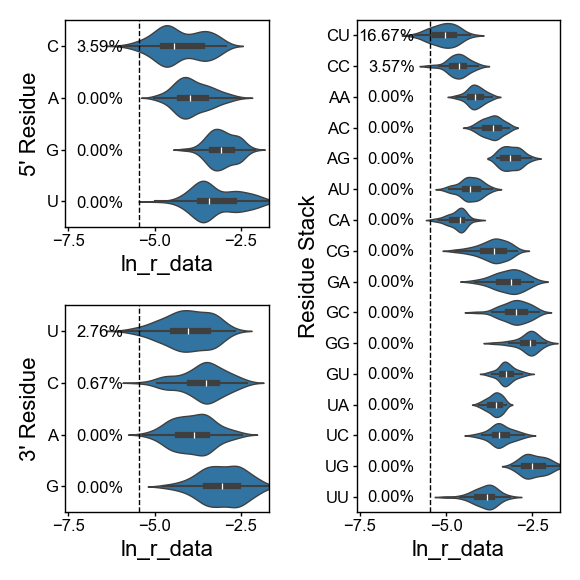

In [ ]:
df_cc_1x1 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC' and m_token == '1x1'"
).copy()
plot_residue_trends(df_cc_1x1, color="tab:blue")

In [ ]:
create_summary_table(df_cc_1x1, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CU        | 16.67%          |      30 |
| CC        | 3.57%           |      28 |
| AA        | 0.00%           |      41 |
| UU        | 0.00%           |      41 |
| AC        | 0.00%           |      50 |
| GU        | 0.00%           |      50 |
| AG        | 0.00%           |      30 |
| AU        | 0.00%           |      60 |
| CA        | 0.00%           |      30 |
| UG        | 0.00%           |      61 |
| GG        | 0.00%           |      28 |
| CG        | 0.00%           |      79 |
| GA        | 0.00%           |      30 |
| UC        | 0.00%           |      30 |
| GC        | 0.00%           |      42 |
| UA        | 0.00%           |      42 |


/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


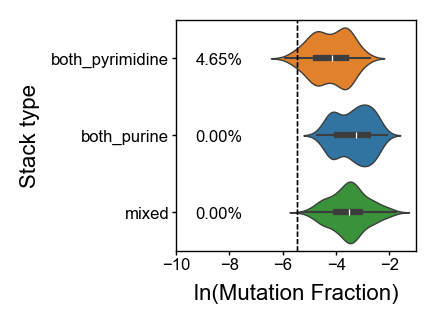

In [ ]:
df_cc_1x1 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC' and m_token == '1x1'"
).copy()
df_cc_1x1["stack_type"] = df_cc_1x1.apply(assign_stack_type, axis=1)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = plot_violins_w_percent(
    df_cc_1x1,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)

# 2x2 double mismatches

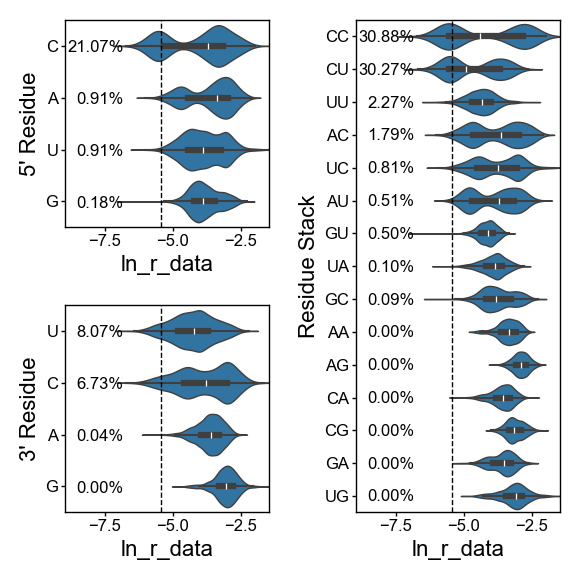

In [ ]:
df_cc_2x2 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC' and m_token == '2x2'"
).copy()
plot_residue_trends(df_cc_2x2, color="tab:blue")

In [ ]:
create_summary_table(df_cc_2x2, "r_stack")
# with PDB info with known pairs

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CC        | 30.88%          |    1143 |
| CU        | 30.27%          |     783 |
| UU        | 2.27%           |    1189 |
| AC        | 1.79%           |    1785 |
| UC        | 0.81%           |    1981 |
| AU        | 0.51%           |     987 |
| GU        | 0.50%           |     401 |
| UA        | 0.10%           |     993 |
| GC        | 0.09%           |    1063 |
| AA        | 0.00%           |     798 |
| GA        | 0.00%           |     202 |
| AG        | 0.00%           |     492 |
| CA        | 0.00%           |     593 |
| CG        | 0.00%           |     281 |
| UG        | 0.00%           |     683 |


# with PDB info with known pairs

## stacking

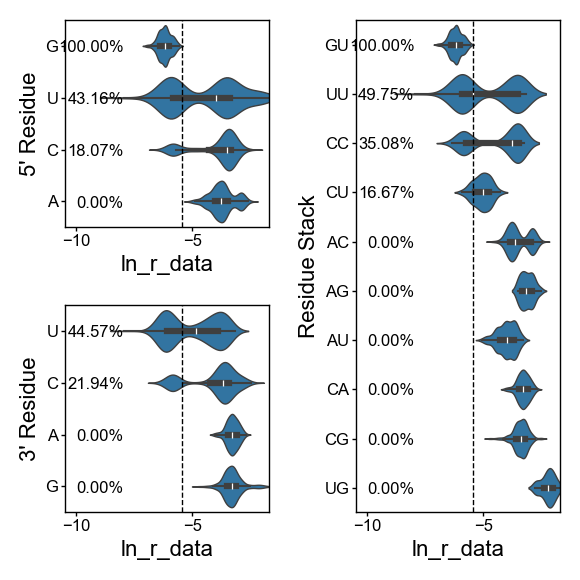

In [ ]:
df_pdb_cc = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-C' and no_of_interactions == 1"
).copy()
plot_residue_trends(df_pdb_cc, color="tab:blue")

In [ ]:
create_summary_table(df_pdb_cc, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| GU        | 100.00%         |     312 |
| UU        | 49.75%          |     203 |
| CC        | 35.08%          |     496 |
| CU        | 16.67%          |      60 |
| AC        | 0.00%           |     297 |
| AU        | 0.00%           |     374 |
| AG        | 0.00%           |      60 |
| CG        | 0.00%           |     359 |
| UG        | 0.00%           |      31 |
| CA        | 0.00%           |     103 |


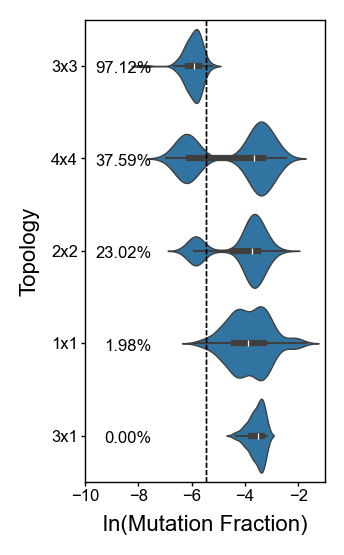

In [ ]:
fig, ax = plt.subplots(figsize=(2.0, 3.0), dpi=200)
ax = plot_violins_w_percent(
    df_pdb_cc,
    "ln_r_data",
    "m_token",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Topology")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)

In [ ]:
df_pdb_cc.query("m_token.isnull()")

,m_sequence,r_nuc,pdb_r_pos,r_type,pdb_r_bp_type,pdb_r_pair,no_of_conformations,no_of_interactions,no_of_partner_interactions,pdb_name,...,p5_type,p3_res,p3_type,r_data,r_loc_pos,r_pos,r_stack,ln_r_data,z_score,r_data_outlier


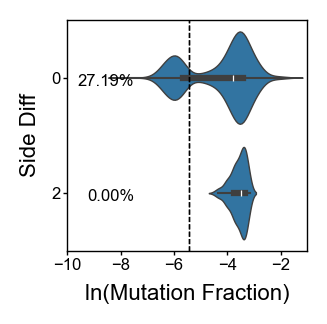

In [ ]:
df_pdb_cc = df_pdb_cc.query("not m_token.isnull()")
df_pdb_cc = df_pdb_cc.query("m_token != '6x3'")
df_pdb_cc.query("m_token.isnull()")
df_pdb_cc = add_side_diff_column(df_pdb_cc)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = plot_violins_w_percent(
    df_pdb_cc,
    "ln_r_data",
    "side_diff",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Side Diff")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)

## distance vs mutation fraction

In [196]:
df_dist = pd.read_csv("../data/pdb-features/distances_all.csv")

In [197]:
def calculate_atom_distances(df, df_dist, r_atom, pair_atom):
    data = []
    data_ratio = []
    seen = []
    for i, g in df.groupby(["pdb_name", "pdb_r_pos"]):
        row = g.iloc[0]
        if row["pair_pdb_r_pos"] == -1:
            continue
        if row.pdb_r_pos < row.pair_pdb_r_pos:
            df_sub = df_dist.query(
                f'pdb_name == "{row.pdb_name}" and '
                f"res_num1 == {row.pdb_r_pos} and res_num2 == {row.pair_pdb_r_pos} and "
                f'atom_name1 == "{r_atom}" and atom_name2 == "{pair_atom}"'
            )
        else:
            df_sub = df_dist.query(
                f'pdb_name == "{row.pdb_name}" and '
                f"res_num1 == {row.pair_pdb_r_pos} and res_num2 == {row.pdb_r_pos} and "
                f'atom_name1 == "{pair_atom}" and atom_name2 == "{r_atom}"'
            )
        if len(df_sub) == 0:
            # print("couldnt find distance")
            continue
        data.append(
            {
                "pdb_name": row.pdb_path,
                "pdb_r_pos": row.pdb_r_pos,
                "pair_pdb_r_pos": row.pair_pdb_r_pos,
                "pdb_r_bp_type": row.pdb_r_bp_type,
                "distance": df_sub.iloc[0]["distance"],
                "pdb_res": row.pdb_res,
                "ln_r_data_mean": g["ln_r_data"].mean(),
                "ln_r_data_std": g["ln_r_data"].std(),
            }
        )
        key = (row.pdb_name, row.pdb_r_pos, row.pair_pdb_r_pos)
        partner_key = (row.pdb_name, row.pair_pdb_r_pos, row.pdb_r_pos)
        if key in seen or partner_key in seen:
            continue
        seen.append(key)
        seen.append(partner_key)
        partner_g = df.query(
            f'pdb_name == "{row.pdb_name}" and pdb_r_pos == {row.pair_pdb_r_pos}'
        )
        ratio = g["ln_r_data"].mean() / partner_g["ln_r_data"].mean()
        data_ratio.append(
            {
                "pdb_name": row.pdb_path,
                "pdb_r_pos": row.pdb_r_pos,
                "pair_pdb_r_pos": row.pair_pdb_r_pos,
                "distance": df_sub.iloc[0]["distance"],
                "pdb_res": row.pdb_res,
                "ratio": ratio,
            }
        )
        if len(partner_g) == 0:
            continue
    return pd.DataFrame(data), pd.DataFrame(data_ratio)


# Example usage:
df_pdb_cc = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-C' and no_of_interactions == 1"
).copy()
df_dist_cc, df_dist_cc_ratio = calculate_atom_distances(
    df_pdb_cc, df_dist, "C2'", "OP2"
)

In [198]:
len(df_dist_cc), len(df_dist_cc_ratio)

(35, 18)

Text(0.5, 1.0, 'Distance N3-N4 vs Mean ln(r_data) (R² = 0.624)')

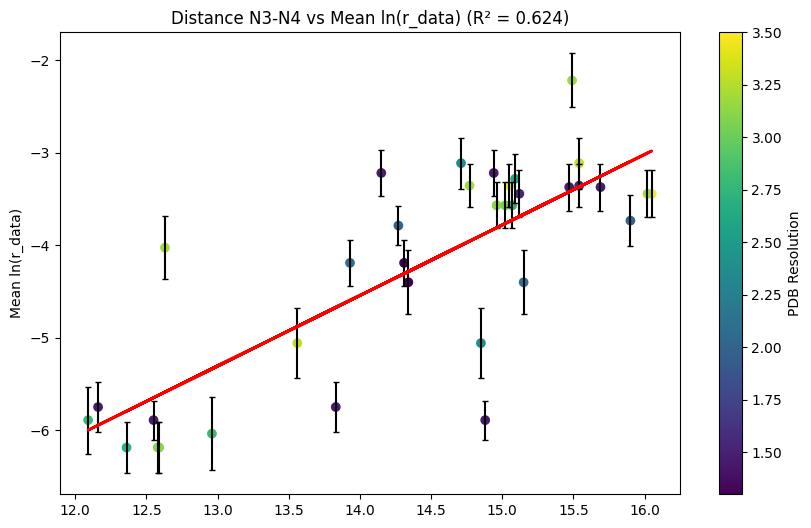

In [203]:
# Prepare the data
X = df_dist_cc["distance"].values.reshape(-1, 1)
y = df_dist_cc["ln_r_data_mean"].values
y_err = df_dist_cc["ln_r_data_std"].values

# Remove any rows with NaN values
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y) & ~np.isnan(y_err)
X = X[mask]
y = y[mask]
y_err = y_err[mask]
pdb_res = df_dist_cc["pdb_res"].values[mask]

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Compute R-squared
r2 = r2_score(y, model.predict(X))

# Create scatter plot with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(X.flatten(), y, yerr=y_err, fmt="none", ecolor="black", capsize=2)
scatter = plt.scatter(X.flatten(), y, c=pdb_res, cmap="viridis")
cbar = plt.colorbar(scatter)
cbar.set_label("PDB Resolution")

# Add regression line
plt.plot(X, model.predict(X), color="red", linewidth=2)

plt.ylabel("Mean ln(r_data)")
plt.title(f"Distance N3-N4 vs Mean ln(r_data) (R² = {r2:.3f})")

Text(0.5, 1.0, 'Distance N3-N4 vs Mean ln(r_data) (R² = 0.553)')

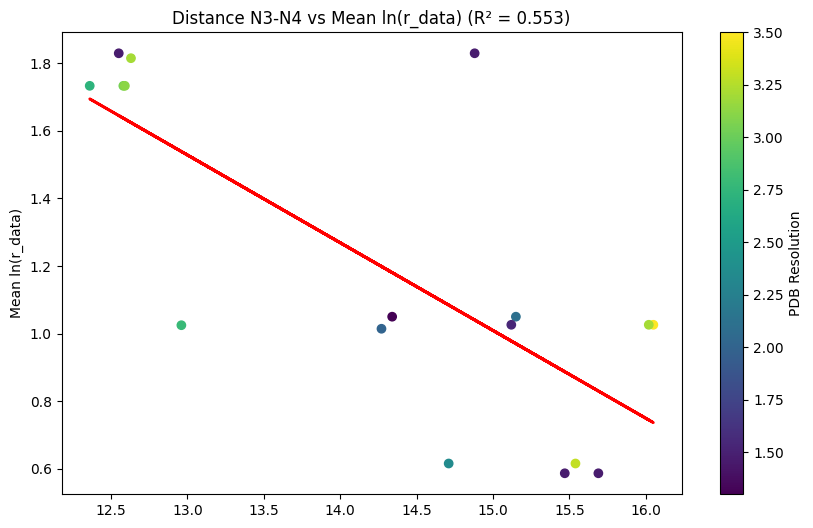

In [202]:
# Prepare the data
X = df_dist_cc_ratio["distance"].values.reshape(-1, 1)
y = df_dist_cc_ratio["ratio"].values
y_err = df_dist_cc_ratio["ratio"].values

# Remove any rows with NaN values
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y) & ~np.isnan(y_err)
X = X[mask]
y = y[mask]
y_err = y_err[mask]
pdb_res = df_dist_cc_ratio["pdb_res"].values[mask]

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Compute R-squared
r2 = r2_score(y, model.predict(X))

# Create scatter plot with error bars
plt.figure(figsize=(10, 6))
# plt.errorbar(X.flatten(), y, yerr=y_err, fmt='none', ecolor='black', capsize=2)
scatter = plt.scatter(X.flatten(), y, c=pdb_res, cmap="viridis")
cbar = plt.colorbar(scatter)
cbar.set_label("PDB Resolution")

# Add regression line
plt.plot(X, model.predict(X), color="red", linewidth=2)

plt.ylabel("Mean ln(r_data)")
plt.title(f"Distance N3-N4 vs Mean ln(r_data) (R² = {r2:.3f})")

In [177]:
# Create a function to compute R-squared and count points for a given PDB resolution cutoff
def compute_r2_and_count_for_cutoff(df, cutoff):
    mask = (
        (df["pdb_res"] <= cutoff)
        & (~df["pdb_res"].isna())
        & (~df["ln_r_data_mean"].isna())
    )
    X = df.loc[mask, "distance"].values.reshape(-1, 1)
    y = df.loc[mask, "ln_r_data_mean"].values

    if len(X) < 2:  # Need at least two points for regression
        return np.nan, 0

    model = LinearRegression()
    model.fit(X, y)
    return r2_score(y, model.predict(X)), len(X)


# Define PDB resolution cutoffs
cutoffs = [1.5, 1.80, 2.0, 2.5, 3.0, 3.5, float("inf")]

# Compute R-squared and count points for each cutoff
results = []
for cutoff in cutoffs:
    r2, count = compute_r2_and_count_for_cutoff(df_dist_cc, cutoff)
    results.append({"Cutoff": cutoff, "R-squared": r2, "Count": count})

table_data = [
    [
        f"≤ {cutoff:.1f}" if cutoff != float("inf") else "All",
        f"{r2:.3f}" if not np.isnan(r2) else "N/A",
        f"{count}",
    ]
    for cutoff, r2, count in zip(
        cutoffs, [r["R-squared"] for r in results], [r["Count"] for r in results]
    )
]

print(
    tabulate(
        table_data,
        headers=["PDB Resolution Cutoff", "R-squared", "Number of Points"],
        tablefmt="pipe",
    )
)

| PDB Resolution Cutoff   |   R-squared |   Number of Points |
|:------------------------|------------:|-------------------:|
| ≤ 1.5                   |       0.311 |                 10 |
| ≤ 1.8                   |       0.225 |                 12 |
| ≤ 2.0                   |       0.202 |                 14 |
| ≤ 2.5                   |       0.134 |                 18 |
| ≤ 3.0                   |       0.203 |                 23 |
| ≤ 3.5                   |       0.259 |                 35 |
| All                     |       0.259 |                 35 |


In [170]:
pair_atoms = list(df_dist.query("res_name1 == 'C'")["atom_name1"].unique())

In [187]:
for pair_atom in pair_atoms:
    try:
        df_dist_cc, df_dist_cc_ratio = calculate_atom_distances(
            df_pdb_cc, df_dist, "N3", pair_atom
        )
        df_dist_cc.dropna(inplace=True)
        r2_val = pearsonr(df_dist_cc["distance"], df_dist_cc["ln_r_data_mean"])[0] ** 2
        df_dist_cc_sub = df_dist_cc.query("pdb_res < 2.0")
        r2_val_sub = (
            pearsonr(df_dist_cc_sub["distance"], df_dist_cc_sub["ln_r_data_mean"])[0]
            ** 2
        )
        print(pair_atom, r2_val, len(df_dist_cc), r2_val_sub, len(df_dist_cc_sub))
    except:
        pass

N1 0.002085935271204726 35 0.0898023833601925 12
C2 0.014899319958317574 35 0.1541695691300308 12
O2 0.08364993054730774 35 0.2249873728353094 12
N3 0.09146291844210538 35 0.001053973181162385 12
C4 0.28653593252693255 35 0.19500458550998093 12
N4 0.2593983072719665 35 0.22528696873662118 12
C5 0.25149323924908495 35 0.2156002389238372 12
C6 0.16718952305192103 35 0.08161608208767575 12
O4' 0.02305771259165322 35 0.10637081549962905 12
C3' 0.05954099478772523 35 0.21052244449471152 12
C1' 0.05394943422094415 35 0.1797301603669103 12
C2' 0.09547266751374771 35 0.25171499492558663 12
O2' 0.10909213511045657 30 0.16678755555509997 11
O5' 0.011456639683947528 19 0.371245566724186 5
C4' 0.010013482976511655 27 0.07199016016394368 11
O3' 0.006453947055505134 18 0.12353834477196982 6
OP2 0.09554573811821193 12 0.23751755191044985 4


In [191]:
for pair_atom in pair_atoms:
    try:
        df_dist_cc, df_dist_cc_ratio = calculate_atom_distances(
            df_pdb_cc, df_dist, "N3", pair_atom
        )
        df_dist_cc_ratio.dropna(inplace=True)
        r2_val = (
            pearsonr(df_dist_cc_ratio["distance"], df_dist_cc_ratio["ratio"])[0] ** 2
        )
        df_dist_cc_sub = df_dist_cc_ratio.query("pdb_res < 2.0")
        r2_val_sub = (
            pearsonr(df_dist_cc_ratio["distance"], df_dist_cc_ratio["ratio"])[0] ** 2
        )
        print(pair_atom, r2_val, len(df_dist_cc_ratio), r2_val_sub, len(df_dist_cc_sub))
    except:
        pass

N1 0.00121578148084027 17 0.00121578148084027 6
C2 0.06025680351203128 17 0.06025680351203128 6
O2 0.24462248394909378 17 0.24462248394909378 6
N3 0.0786420676218157 17 0.0786420676218157 6
C4 0.4172699790734651 17 0.4172699790734651 6
N4 0.44581762266968267 17 0.44581762266968267 6
C5 0.45114084829181683 17 0.45114084829181683 6
C6 0.307494575481587 17 0.307494575481587 6
O4' 0.01725279682591782 17 0.01725279682591782 6
C3' 0.08889369897143388 17 0.08889369897143388 6
C1' 0.11243204503081505 17 0.11243204503081505 6
C2' 0.21762260640971853 17 0.21762260640971853 6
O2' 0.27120124272035145 17 0.27120124272035145 6
O5' 0.0033250553051040526 12 0.0033250553051040526 4
C4' 0.15058357165394068 17 0.15058357165394068 6
O3' 0.20312339528817652 16 0.20312339528817652 6
C5' 0.0992188185091999 7 0.0992188185091999 1
P 0.1757410180449687 5 0.1757410180449687 1
OP2 0.30092153788700066 10 0.30092153788700066 3
